Ouvrir ce notebook dans :
<a href="https://colab.research.google.com/github/joanglaunes/deep_learning_image/blob/main/Mnist-denoising.ipynb" target="_blank">Google Colab</a>
ou
<a href="https://rosenblatt.ens.math-info.univ-paris5.fr/hub/user-redirect/git-pull?repo=https%3A%2F%2Fgithub.com%2Fjoanglaunes%2Fdeep_learning_image&urlpath=tree%2Fdeep_learning_image%2FMnist-denoising.ipynb&branch=main" target="_blank">Rosenblatt</a>

Exemple de réseau convolutionnel simple pour le denoising.

Cet exemple est censé être lu après avoir lu l'exemple "mnist", dont il est directement dérivé. Seuls les parties différentes sont commentées.

<br>
<br>
<br>
Imports des librairies, paramètres généraux et définition du jeu de données. Cette partie est quasi inchangée, seul le paramètre num_classes est supprimé ici, car on ne se trouve plus dans un problème de classification (les classes ne joueront aucun rôle).

In [1]:
#imports
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms

import math
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [16, 8]

# Device configuration
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

# Hyper parameters
num_epochs = 5
batch_size = 100
learning_rate = 0.0001

# MNIST dataset
train_dataset = torchvision.datasets.MNIST(root='data/',
                                           train=True,
                                           transform=transforms.ToTensor(),
                                           download=True)

test_dataset = torchvision.datasets.MNIST(root='data/',
                                          train=False,
                                          transform=transforms.ToTensor())

# Data loader
train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                           batch_size=batch_size,
                                           shuffle=True)

test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                          batch_size=batch_size,
                                          shuffle=False)

In [2]:
def salt_and_pepper(images,prob=.1):
    images_noisy = images.clone()
    rnd = torch.rand(images.shape)
    images_noisy[rnd<prob] = 0
    images_noisy[rnd>1-prob] = 1
    return images_noisy

def show_images(images, nrows=1, title=None):
    plt.figure(figsize=(plt.rcParams['figure.figsize'][0],0.1))
    plt.axis("off")
    plt.title(title)
    plt.show()
    nb_ims = images.shape[0]
    ncols = math.ceil(nb_ims/nrows)
    for k,im in enumerate(images):
        plt.subplot(nrows, ncols, k+1)
        plt.imshow(images[k,:,:], cmap="gray")
        plt.axis("off")
    plt.show()
    plt.figure(figsize=(plt.rcParams['figure.figsize'][0],0.3))
    plt.axis("off")
    plt.show()

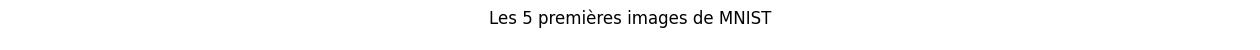

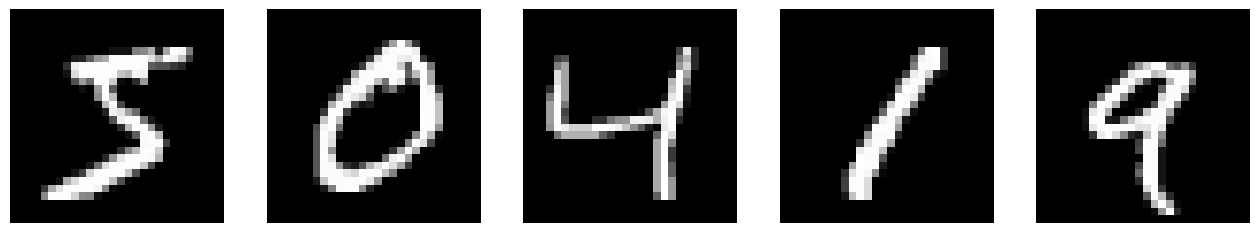

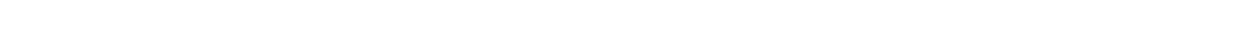

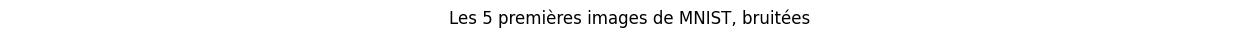

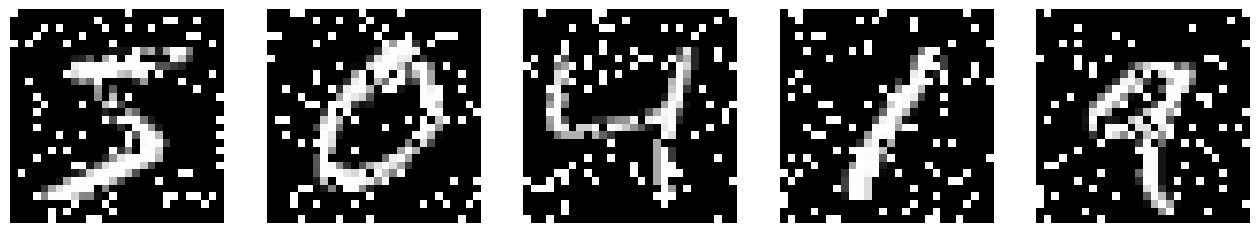

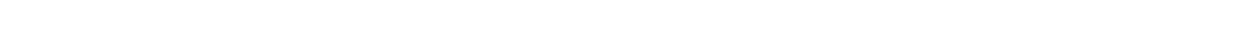

In [3]:
# 5 premières images
train_images_sample = train_dataset.data[:5,:,:].float()/255
train_images_sample_noisy = salt_and_pepper(train_images_sample)

show_images(train_images_sample, title="Les 5 premières images de MNIST")
show_images(train_images_sample_noisy, title="Les 5 premières images de MNIST, bruitées")

<br>
<br>
<br>
Définition du réseau. 

In [4]:

# Convolutional neural network
class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()
        self.op = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=5, stride=1, padding=2),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            #nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(16, 32, kernel_size=5, stride=1, padding=2),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            #nn.MaxPool2d(kernel_size=2, stride=2))

            nn.Conv2d(32, 16, kernel_size=5, stride=1, padding=2),
            nn.BatchNorm2d(16),
            nn.ReLU(),

            nn.Conv2d(16, 1, kernel_size=5, stride=1, padding=2),
            nn.BatchNorm2d(1),
            nn.ReLU(),

            nn.Sigmoid()
        )

    def forward(self, x):
        # encoding
        out = self.op(x)
        return out

model = ConvNet().to(device)

# optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

<br>
<br>
<br>
Entraînement du réseau. Ici la seule mais fondamentale différence est que la fonction coût évalue la différence
entre la sortie du réseau et les images d''entrée, et non plus entre la sortie et les classes.
Ici le critère utilisé est celui des moindres carrés.

In [5]:
# Train the model
lossfun = nn.BCELoss()
print("beginning training...")
total_step = len(train_loader)
for epoch in range(num_epochs):
    for i, (images, _) in enumerate(train_loader):
        images = images.to(device)
        images_noisy = salt_and_pepper(images)

        # Forward pass
        outputs = model(images_noisy)
        loss = lossfun(outputs,images)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if (i+1) % 100 == 0:
            print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}'
                   .format(epoch+1, num_epochs, i+1, total_step, loss.item()))
print("training done")

beginning training...
Epoch [1/5], Step [100/600], Loss: 0.6539
Epoch [1/5], Step [200/600], Loss: 0.6496
Epoch [1/5], Step [300/600], Loss: 0.6476
Epoch [1/5], Step [400/600], Loss: 0.6462
Epoch [1/5], Step [500/600], Loss: 0.6472
Epoch [1/5], Step [600/600], Loss: 0.6466
Epoch [2/5], Step [100/600], Loss: 0.6431
Epoch [2/5], Step [200/600], Loss: 0.6461
Epoch [2/5], Step [300/600], Loss: 0.6435
Epoch [2/5], Step [400/600], Loss: 0.6461
Epoch [2/5], Step [500/600], Loss: 0.6466
Epoch [2/5], Step [600/600], Loss: 0.6483
Epoch [3/5], Step [100/600], Loss: 0.6446
Epoch [3/5], Step [200/600], Loss: 0.6473
Epoch [3/5], Step [300/600], Loss: 0.6431
Epoch [3/5], Step [400/600], Loss: 0.6418
Epoch [3/5], Step [500/600], Loss: 0.6420
Epoch [3/5], Step [600/600], Loss: 0.6456
Epoch [4/5], Step [100/600], Loss: 0.6454
Epoch [4/5], Step [200/600], Loss: 0.6446
Epoch [4/5], Step [300/600], Loss: 0.6416
Epoch [4/5], Step [400/600], Loss: 0.6421
Epoch [4/5], Step [500/600], Loss: 0.6435
Epoch [4/5],

<br>
<br>
<br>
On affiche la sortie du réseau pour cinq images test. Ces sorties sont censées être des images très proches des images d'entrée car le réseau a été entraîné pour ça.

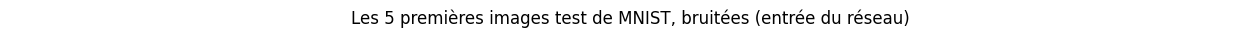

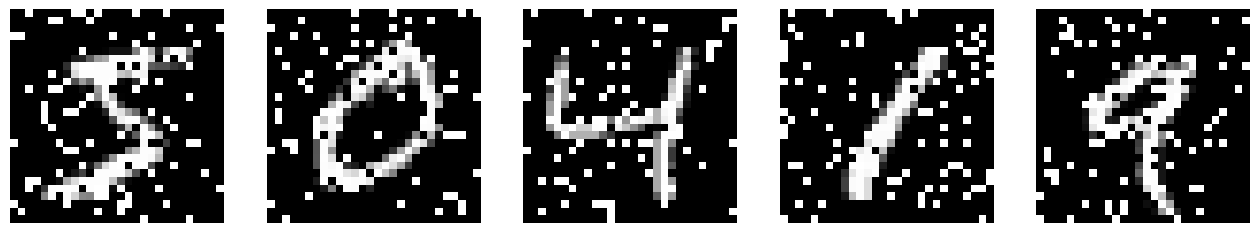

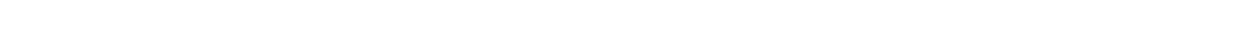

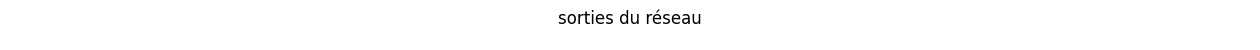

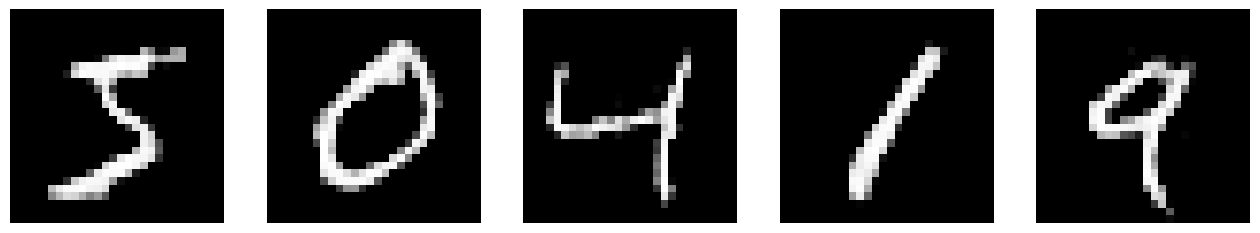

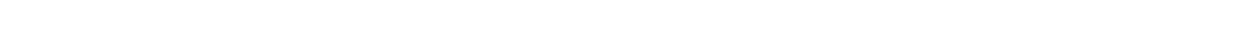

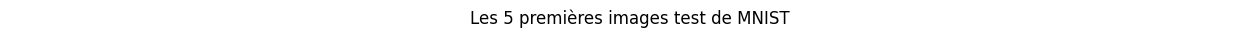

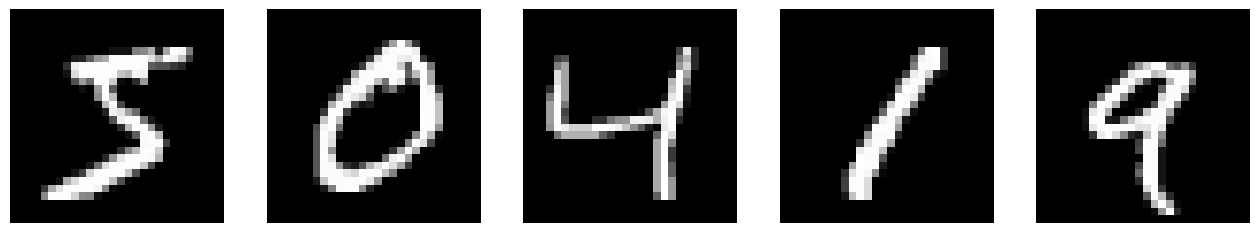

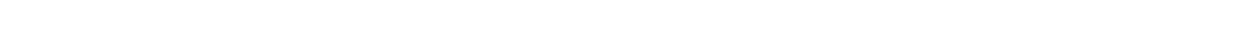

In [15]:
test_images_sample = train_dataset.data[:5,:,:].float()/255
test_images_sample_noisy = salt_and_pepper(test_images_sample)

outputs = model(test_images_sample_noisy[:,None,...].to(device))[:,0,:,:].detach().cpu()

show_images(test_images_sample_noisy, title="Les 5 premières images test de MNIST, bruitées (entrée du réseau)")
show_images(outputs, title="sorties du réseau")
show_images(test_images_sample, title="Les 5 premières images test de MNIST")